## Setup

In [1]:
import os
import glob
from PIL import Image
from collections import namedtuple
import torch
import torchvision.transforms as transforms
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from srresnet import ConvolutionalBlock, SubPixelConvolutionalBlock, ResidualBlock, SRResNet

/home/frauke/anaconda3/envs/super-res/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Model from Checkpoint

In [2]:
path = '../saved_models'
checkpoint = torch.load(os.path.join(path, 'best_model-epoch=223-val_loss=0.29.ckpt'), 
                        map_location=torch.device('cpu'))

In [3]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict', 'hparams_name', 'hyper_parameters'])

In [4]:
checkpoint["state_dict"].keys()

odict_keys(['conv_block1.conv_block.0.weight', 'conv_block1.conv_block.0.bias', 'conv_block1.conv_block.1.weight', 'residual_blocks.0.conv_block1.conv_block.0.weight', 'residual_blocks.0.conv_block1.conv_block.0.bias', 'residual_blocks.0.conv_block1.conv_block.1.weight', 'residual_blocks.0.conv_block1.conv_block.1.bias', 'residual_blocks.0.conv_block1.conv_block.1.running_mean', 'residual_blocks.0.conv_block1.conv_block.1.running_var', 'residual_blocks.0.conv_block1.conv_block.1.num_batches_tracked', 'residual_blocks.0.conv_block1.conv_block.2.weight', 'residual_blocks.0.conv_block2.conv_block.0.weight', 'residual_blocks.0.conv_block2.conv_block.0.bias', 'residual_blocks.0.conv_block2.conv_block.1.weight', 'residual_blocks.0.conv_block2.conv_block.1.bias', 'residual_blocks.0.conv_block2.conv_block.1.running_mean', 'residual_blocks.0.conv_block2.conv_block.1.running_var', 'residual_blocks.0.conv_block2.conv_block.1.num_batches_tracked', 'residual_blocks.1.conv_block1.conv_block.0.weight

In [5]:
print(checkpoint["hyper_parameters"])

{'debug': False, 'data_dir': '/work/ka1176/frauke/super-resolution/data', 'output_path': '/work/ka1176/frauke/super-resolution/nni/nni-experiments/abj60ped/trials/aDYYA/preds.h5', 'save_model_path': '/work/ka1176/frauke/super-resolution/nni/nni-experiments/abj60ped/trials/aDYYA/saved_models', 'batch_size': 8, 'learning_rate': 0.001, 'scaling_factor': 4, 'n_channels': 16, 'large_kernel_size': 9, 'small_kernel_size': 3, 'n_blocks': 28, 'n_epochs': 1000, 'nni': True, 'logger': True, 'checkpoint_callback': True, 'default_root_dir': None, 'gradient_clip_val': 0, 'process_position': 0, 'num_nodes': 1, 'num_processes': 1, 'gpus': 1, 'auto_select_gpus': False, 'tpu_cores': <function _gpus_arg_default at 0x7f80c8272c10>, 'log_gpu_memory': None, 'progress_bar_refresh_rate': None, 'overfit_batches': 0.0, 'track_grad_norm': -1, 'check_val_every_n_epoch': 1, 'fast_dev_run': False, 'accumulate_grad_batches': 1, 'max_epochs': None, 'min_epochs': None, 'max_steps': None, 'min_steps': None, 'limit_trai

In [6]:
# convert dictionary to object to access values via dot notation
args = namedtuple("ObjectName", checkpoint["hyper_parameters"].keys())(*checkpoint["hyper_parameters"].values())

In [7]:
args.debug

False

In [8]:
model = SRResNet(args)

times subpixel: 2


In [10]:
#model2 = SRResNet.load_from_checkpoint(chk_path, layers=3, drop_rate=0)
model = SRResNet.load_from_checkpoint(os.path.join(path, 'best_model-epoch=223-val_loss=0.29.ckpt'), 
                                      map_location=torch.device('cpu'),
                                      args=args)

times subpixel: 2


In [11]:
model.eval()

SRResNet(
  (conv_block1): ConvolutionalBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): PReLU(num_parameters=1)
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv_block1): ConvolutionalBlock(
        (conv_block): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
        )
      )
      (conv_block2): ConvolutionalBlock(
        (conv_block): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): ResidualBlock(
      (conv_block1): ConvolutionalBlock(
        (conv_block): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

## Load low resolution Images

In [12]:
path_lr = '../data/LR'
imgs_lr = glob.glob(f"{path_lr}/*.png")
imgs_lr[:5]

['../data/LR/0.png',
 '../data/LR/6.png',
 '../data/LR/4.png',
 '../data/LR/79.png',
 '../data/LR/23.png']

## Preprocessing

In [13]:
# to tensor
# normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

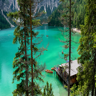

In [14]:
# load image
path = imgs_lr[1]
img_lr = Image.open(path)#np.asarray(Image.open(path))
img_lr#[0][:5]

In [15]:
x = transform(img_lr)
x.shape

torch.Size([3, 96, 96])

## Apply Model

In [17]:
# expand dimension for batch dim
X = x[None,:] # (bs, channel, width, height)
X.shape

torch.Size([1, 3, 96, 96])

In [18]:
y = model(X)
y = y
y.shape

torch.Size([1, 3, 384, 384])

## Plot resulting Image

In [20]:
torch.max(y), torch.min(y)

(tensor(1., grad_fn=<MaxBackward1>), tensor(-1., grad_fn=<MinBackward1>))

In [21]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_rev = -(mean/std)
std_rev = 1/std
un_transform = transforms.Compose([transforms.Normalize(mean_rev, std_rev)])

In [38]:
y = un_transform(y.squeeze())

In [32]:
img_hr = y.squeeze()
print(img_hr.shape)
img_hr = np.swapaxes(img_hr, 0, 2)
print(img_hr.shape)
img_hr = np.swapaxes(img_hr, 0, 1)
print(img_hr.shape)

torch.Size([3, 384, 384])
torch.Size([384, 384, 3])
torch.Size([384, 384, 3])


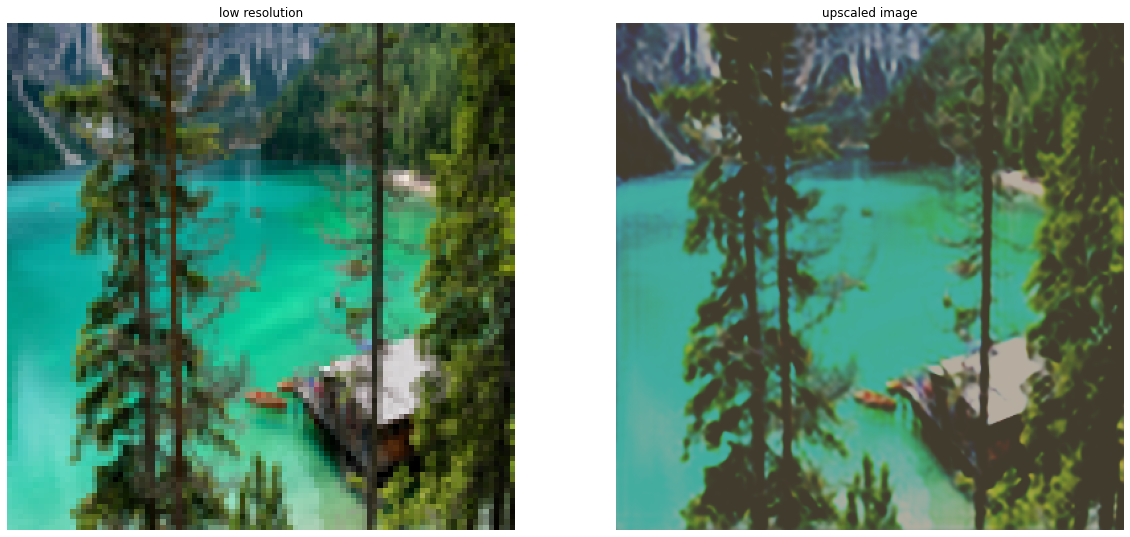

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_lr)
axes[0].axis('off')
axes[0].set_title('low resolution')
axes[1].imshow(img_hr.detach().numpy())
axes[1].axis('off')
axes[1].set_title('upscaled image')
plt.savefig("example_prediction.png")
plt.show()